In [3]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 7.7MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 8.3MB/s 


In [4]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-03 15:21:36--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-03 15:21:36--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6cc2ff35c4f6a06334723084f4.dl.dropboxusercontent.com/cd/0/get/BJ-INi7GPgVfock7CVH7MCL8bfmklbs1UzMX_WPGKFBtXNS4iY4yQUNRylyo6YPnf3XK1TINna54Ezcn2QXICxpchWOivV9yDmHF-fgwiASj6t13YH6IqovU6y5sjXNuzA4/file?dl=1# [following]
--2021-03-03 15:21:36--  https://uc6cc2ff35c4f6a06334723084f4.dl.dropboxusercontent.com/cd/0/get/BJ-INi7GPgVfock7CVH7MCL8bfmklbs1UzMX_WPGKFBtXNS4iY4yQUNRylyo6YPnf3XK1TINna54Ezcn2QXIC

In [5]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [6]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [7]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [8]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [9]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [10]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [11]:
modelo='resnest50d'

## Ranger

In [12]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [13]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=7.585775847473997e-07)

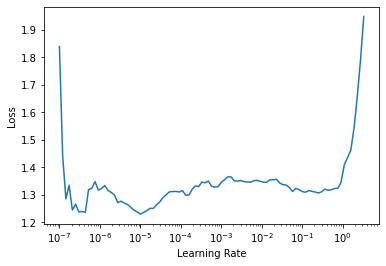

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.320021,0.957922,0.518349,0.540698,0.542274,00:32
1,1.264050,0.879027,0.553517,0.569482,0.609329,00:31


Better model found at epoch 0 with valid_loss value: 0.9579222202301025.


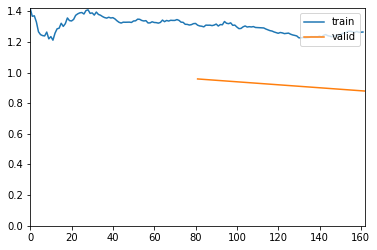

Better model found at epoch 1 with valid_loss value: 0.8790271878242493.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.239444,0.877973,0.550459,0.572700,0.562682,00:38
1,1.200437,0.853285,0.559633,0.583082,0.562682,00:37
2,1.214443,0.851625,0.545872,0.568862,0.553936,00:37
3,1.166641,0.829784,0.562691,0.599303,0.501458,00:37
4,1.122793,0.817348,0.559633,0.579251,0.586006,00:37
5,1.110678,0.805280,0.562691,0.579832,0.603499,00:37
6,1.088099,0.814457,0.562691,0.582609,0.586006,00:37
7,1.070214,0.788631,0.565749,0.589124,0.568513,00:37
8,1.086986,0.781419,0.562691,0.586626,0.562682,00:37
9,1.048425,0.789088,0.559633,0.585139,0.551020,00:37


Better model found at epoch 0 with valid_loss value: 0.8779733777046204.


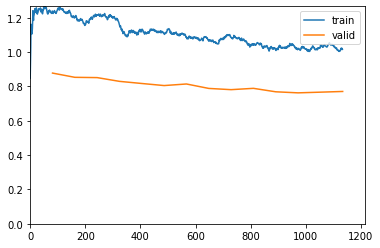

Better model found at epoch 1 with valid_loss value: 0.853285014629364.
Better model found at epoch 2 with valid_loss value: 0.8516249060630798.
Better model found at epoch 3 with valid_loss value: 0.8297838568687439.
Better model found at epoch 4 with valid_loss value: 0.8173483610153198.
Better model found at epoch 5 with valid_loss value: 0.8052799105644226.
Better model found at epoch 7 with valid_loss value: 0.7886314392089844.
Better model found at epoch 8 with valid_loss value: 0.7814192175865173.
Better model found at epoch 10 with valid_loss value: 0.7689697742462158.
Better model found at epoch 11 with valid_loss value: 0.7628284692764282.
No improvement since epoch 11: early stopping


In [15]:
learn.fine_tune(15,freeze_epochs=2)

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

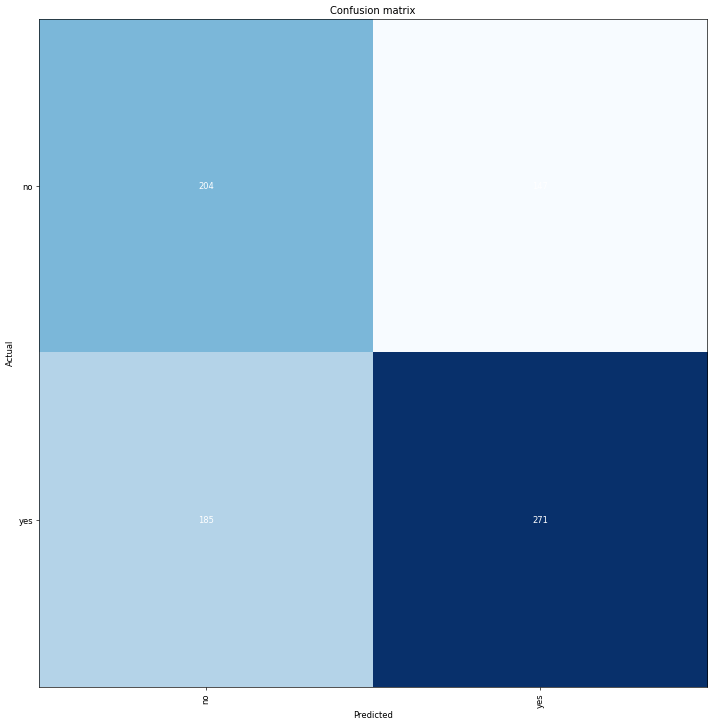

In [17]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5885997414588928.


(#4) [0.7346844673156738,0.5885997414588928,0.6483253588516746,0.5942982456140351]

## Faltten

In [19]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.297186,0.859879,0.571865,0.575904,0.696793,00:31
1,0.941798,0.759916,0.584098,0.606607,0.588921,00:31


Better model found at epoch 0 with valid_loss value: 0.8598785996437073.


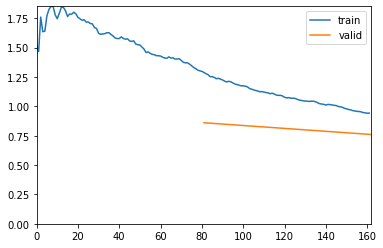

Better model found at epoch 1 with valid_loss value: 0.7599159479141235.


In [20]:
learn.fit_flat_cos(2,lr=1e-3)

In [21]:
learn.unfreeze()

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=6.309573450380412e-07)

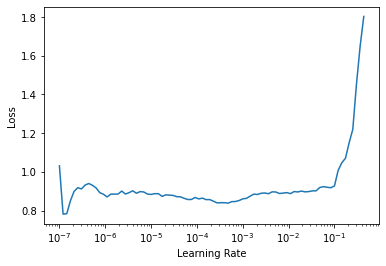

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.013288,1.218541,0.515290,0.521959,0.900875,00:37
1,1.069646,0.865072,0.529052,0.528090,0.959184,00:37
2,1.050746,0.983114,0.478593,0.666667,0.011662,00:37
3,1.053124,0.875991,0.525994,0.525268,1.000000,00:37
4,1.141903,3.053662,0.477064,0.526316,0.029155,00:37


Better model found at epoch 0 with valid_loss value: 1.2185413837432861.


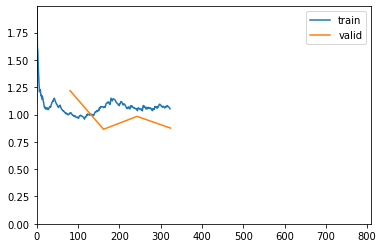

Better model found at epoch 1 with valid_loss value: 0.8650722503662109.
No improvement since epoch 1: early stopping


In [23]:
learn.fit_flat_cos(10,lr=1e-2)

In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

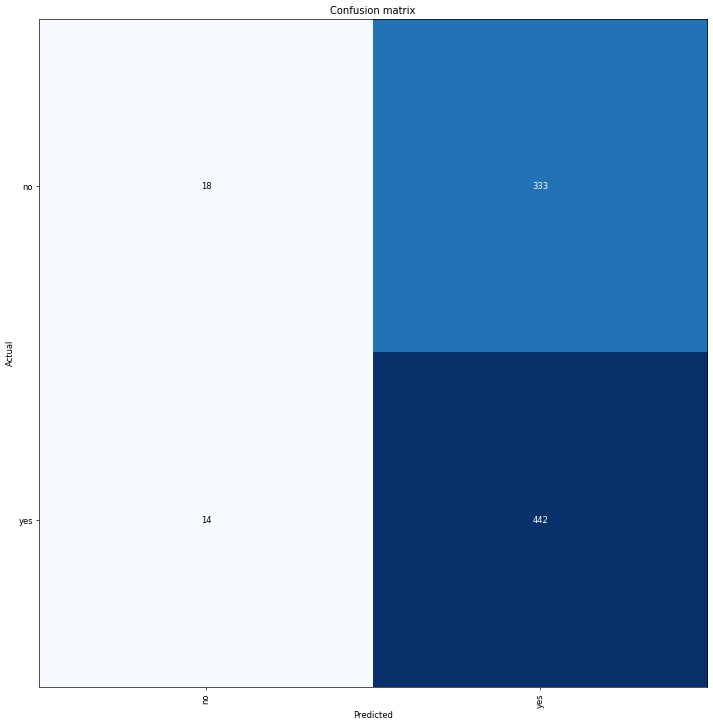

In [25]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5700123906135559.


(#4) [0.8089413642883301,0.5700123906135559,0.5703225806451613,0.9692982456140351]

## LabelSmoothing

In [27]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=1.5848931980144698e-06)

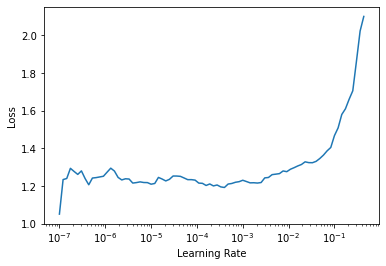

In [28]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.301655,1.077648,0.558104,0.578947,0.577259,00:31
1,1.084759,0.808885,0.550459,0.568245,0.594752,00:31


Better model found at epoch 0 with valid_loss value: 1.0776478052139282.


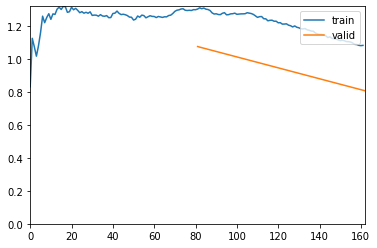

Better model found at epoch 1 with valid_loss value: 0.8088845610618591.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.817131,0.701337,0.590214,0.618297,0.571429,00:37
1,0.763691,0.690976,0.611621,0.653979,0.551020,00:37
2,0.731578,0.688994,0.574924,0.628458,0.463557,00:37
3,0.700474,0.660468,0.626911,0.677419,0.551020,00:37
4,0.676784,0.671588,0.611621,0.653979,0.551020,00:37
5,0.651524,0.648554,0.671254,0.746154,0.565598,00:37
6,0.630449,0.640218,0.651376,0.718631,0.551020,00:37
7,0.610021,0.631884,0.695719,0.750000,0.629738,00:37
8,0.598155,0.628772,0.692661,0.770992,0.588921,00:37
9,0.594474,0.629120,0.689602,0.751799,0.609329,00:37


Better model found at epoch 0 with valid_loss value: 0.7013368010520935.


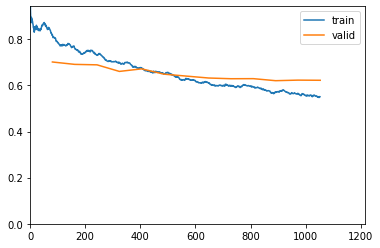

Better model found at epoch 1 with valid_loss value: 0.6909756064414978.
Better model found at epoch 2 with valid_loss value: 0.6889944076538086.
Better model found at epoch 3 with valid_loss value: 0.6604683995246887.
Better model found at epoch 5 with valid_loss value: 0.6485539078712463.
Better model found at epoch 6 with valid_loss value: 0.6402176022529602.
Better model found at epoch 7 with valid_loss value: 0.6318835616111755.
Better model found at epoch 8 with valid_loss value: 0.6287723779678345.
Better model found at epoch 10 with valid_loss value: 0.6202832460403442.
No improvement since epoch 10: early stopping


In [29]:
learn.fine_tune(15,freeze_epochs=2)

In [30]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

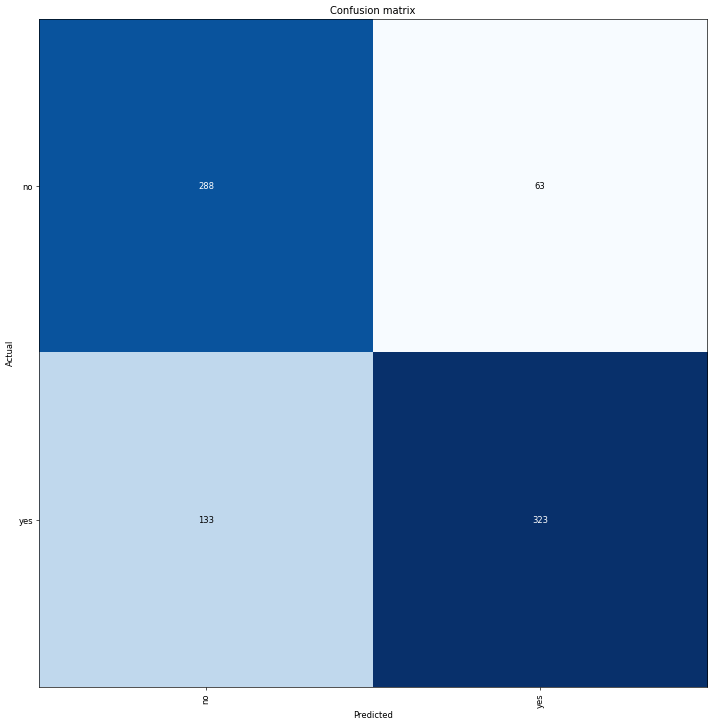

In [31]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [32]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7571251392364502.


(#4) [0.5494374632835388,0.7571251392364502,0.8367875647668394,0.7083333333333334]

## MixUp

In [33]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [37]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.5848931980144698e-06)

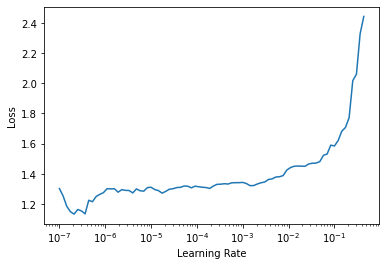

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.285037,1.231789,0.574924,0.648402,0.413994,00:31
1,1.062627,0.786903,0.576453,0.681319,0.361516,00:31


Better model found at epoch 0 with valid_loss value: 1.231788992881775.


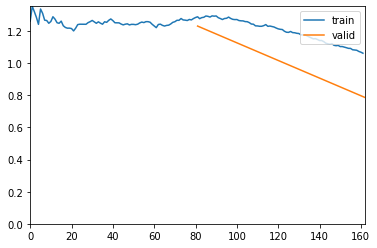

Better model found at epoch 1 with valid_loss value: 0.7869031429290771.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.799477,0.694302,0.570336,0.663158,0.367347,00:37
1,0.762677,0.679877,0.573394,0.624031,0.469388,00:37
2,0.724828,0.693929,0.582569,0.568359,0.848397,00:37
3,0.707813,0.638495,0.637615,0.636598,0.720117,00:37
4,0.685946,0.648169,0.622324,0.631148,0.673469,00:37
5,0.662692,0.650508,0.643731,0.676282,0.615160,00:37
6,0.650955,0.617684,0.663609,0.704319,0.618076,00:37
7,0.645040,0.613257,0.669725,0.732601,0.583090,00:37
8,0.616642,0.627372,0.646789,0.766667,0.469388,00:37
9,0.612145,0.607587,0.668196,0.681034,0.690962,00:37


Better model found at epoch 0 with valid_loss value: 0.6943020820617676.


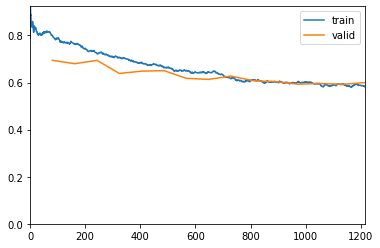

Better model found at epoch 1 with valid_loss value: 0.6798770427703857.
Better model found at epoch 3 with valid_loss value: 0.6384949088096619.
Better model found at epoch 6 with valid_loss value: 0.6176840662956238.
Better model found at epoch 7 with valid_loss value: 0.6132574677467346.
Better model found at epoch 9 with valid_loss value: 0.6075865030288696.
Better model found at epoch 10 with valid_loss value: 0.6036891341209412.
Better model found at epoch 11 with valid_loss value: 0.5929936170578003.
Better model found at epoch 13 with valid_loss value: 0.5923221707344055.


In [38]:
learn.fine_tune(15,freeze_epochs=2)

In [39]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

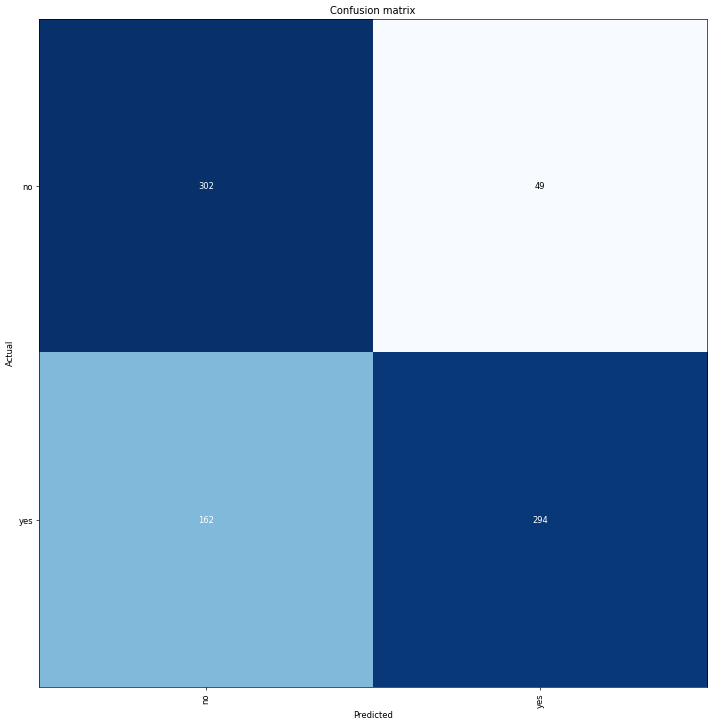

In [40]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [41]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7385377883911133.


(#4) [0.524189293384552,0.7385377883911133,0.8571428571428571,0.6447368421052632]

## Ranger + Flat cosin Anneal

In [42]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.312968,0.959830,0.495413,0.517615,0.556851,00:32
1,1.266367,0.929712,0.495413,0.516624,0.588921,00:32


Better model found at epoch 0 with valid_loss value: 0.9598296284675598.


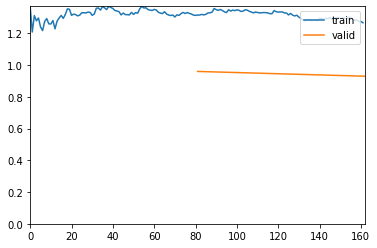

Better model found at epoch 1 with valid_loss value: 0.9297119379043579.


In [43]:
learn.fit_flat_cos(2,lr=1e-3)

In [44]:
learn.unfreeze()

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=1.0964781722577754e-06)

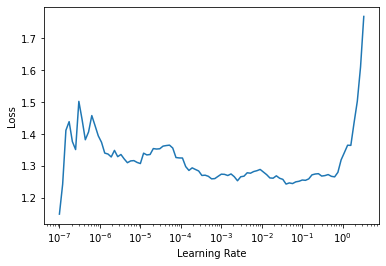

In [45]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.213489,0.963418,0.487768,0.522222,0.274052,00:37
1,1.085984,0.863463,0.512232,0.532258,0.577259,00:37
2,0.994881,0.772946,0.512232,0.540000,0.472303,00:37
3,0.897852,0.762923,0.525994,0.594286,0.303207,00:37
4,0.803539,0.739105,0.527523,0.544503,0.606414,00:37
5,0.752280,0.721111,0.524465,0.574766,0.358601,00:37
6,0.709552,0.721867,0.539755,0.578947,0.448980,00:37
7,0.691935,0.709670,0.555046,0.649425,0.329446,00:37
8,0.672874,0.682363,0.570336,0.651961,0.387755,00:37
9,0.650867,0.683924,0.591743,0.720930,0.361516,00:37


Better model found at epoch 0 with valid_loss value: 0.9634183049201965.


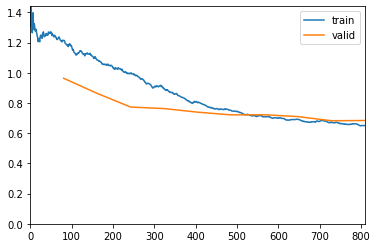

Better model found at epoch 1 with valid_loss value: 0.8634627461433411.
Better model found at epoch 2 with valid_loss value: 0.7729461193084717.
Better model found at epoch 3 with valid_loss value: 0.7629232406616211.
Better model found at epoch 4 with valid_loss value: 0.7391054034233093.
Better model found at epoch 5 with valid_loss value: 0.7211105823516846.
Better model found at epoch 7 with valid_loss value: 0.7096702456474304.
Better model found at epoch 8 with valid_loss value: 0.6823629140853882.


In [46]:
learn.fit_flat_cos(10,lr=1e-2)

In [47]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [48]:
learn.dls = dlsTest

In [49]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6096654534339905.


(#4) [0.6578730940818787,0.6096654534339905,0.7925311203319502,0.41885964912280704]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [50]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.297700,0.884397,0.512232,0.531579,0.588921,00:32
1,1.294559,0.872058,0.527523,0.541667,0.644315,00:32


Better model found at epoch 0 with valid_loss value: 0.8843966126441956.


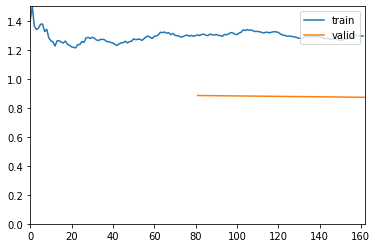

Better model found at epoch 1 with valid_loss value: 0.8720579147338867.


In [51]:
learn.fit_flat_cos(2,lr=1e-3)

In [52]:
learn.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=7.585775847473997e-07)

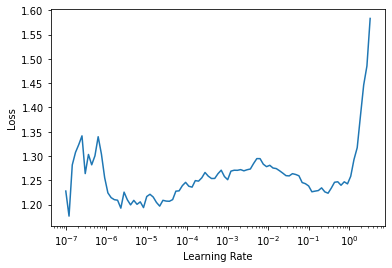

In [53]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.180233,0.819570,0.535168,0.560372,0.527697,00:37
1,1.105365,0.734616,0.562691,0.582133,0.588921,00:37
2,0.986382,0.737633,0.532110,0.555891,0.536443,00:37
3,0.889349,0.717771,0.577982,0.578824,0.717201,00:37
4,0.831549,0.712626,0.529052,0.577778,0.379009,00:37
5,0.759542,0.684608,0.561162,0.586420,0.553936,00:37
6,0.725759,0.673048,0.565749,0.614786,0.460641,00:37
7,0.697620,0.671712,0.605505,0.635783,0.580175,00:37
8,0.685464,0.650423,0.611621,0.626062,0.644315,00:37
9,0.669760,0.651644,0.619266,0.679389,0.518950,00:37


Better model found at epoch 0 with valid_loss value: 0.8195703625679016.


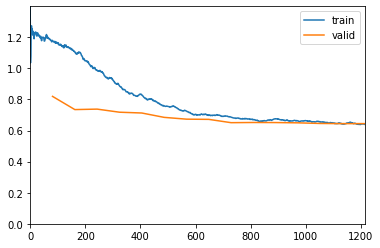

Better model found at epoch 1 with valid_loss value: 0.7346156239509583.
Better model found at epoch 3 with valid_loss value: 0.717770516872406.
Better model found at epoch 4 with valid_loss value: 0.7126264572143555.
Better model found at epoch 5 with valid_loss value: 0.6846083998680115.
Better model found at epoch 6 with valid_loss value: 0.6730482578277588.
Better model found at epoch 7 with valid_loss value: 0.6717117428779602.
Better model found at epoch 8 with valid_loss value: 0.6504232883453369.
Better model found at epoch 11 with valid_loss value: 0.6494012475013733.
Better model found at epoch 12 with valid_loss value: 0.6453731656074524.
Better model found at epoch 13 with valid_loss value: 0.6442943215370178.


In [54]:
learn.fit_flat_cos(15,lr=1e-2)

In [55]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [56]:
learn.dls = dlsTest

In [57]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6394051909446716.


(#4) [0.6441613435745239,0.6394051909446716,0.7956989247311828,0.4868421052631579]

## Ranger +Flat + Label + MixUp

In [63]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.231723,0.928422,0.506116,0.529070,0.530612,00:32
1,1.234175,0.914449,0.484709,0.509146,0.486880,00:32


Better model found at epoch 0 with valid_loss value: 0.9284217357635498.


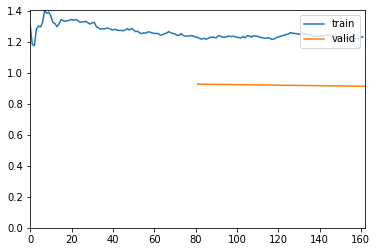

Better model found at epoch 1 with valid_loss value: 0.914449155330658.


In [64]:
learn.fit_flat_cos(2,lr=1e-3)

In [65]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.192793,0.910430,0.521407,0.555556,0.437318,00:37
1,1.083645,0.822649,0.504587,0.539095,0.381924,00:37
2,0.970821,0.728830,0.545872,0.567251,0.565598,00:37
3,0.873157,0.715693,0.568807,0.579634,0.647230,00:37
4,0.808351,0.702927,0.547401,0.569322,0.562682,00:37
5,0.759267,0.690741,0.553517,0.579439,0.542274,00:37
6,0.727145,0.690875,0.550459,0.552463,0.752187,00:37
7,0.710297,0.681024,0.571865,0.581395,0.655977,00:38
8,0.706841,0.683568,0.564220,0.584302,0.586006,00:38
9,0.698777,0.677194,0.590214,0.620579,0.562682,00:38


Better model found at epoch 0 with valid_loss value: 0.9104297757148743.


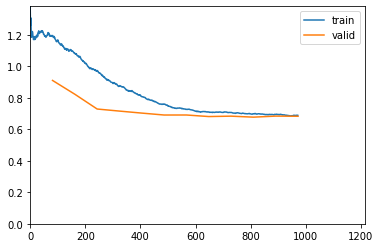

Better model found at epoch 1 with valid_loss value: 0.8226491808891296.
Better model found at epoch 2 with valid_loss value: 0.7288296222686768.
Better model found at epoch 3 with valid_loss value: 0.715693473815918.
Better model found at epoch 4 with valid_loss value: 0.7029265761375427.
Better model found at epoch 5 with valid_loss value: 0.690741240978241.
Better model found at epoch 7 with valid_loss value: 0.6810243725776672.
Better model found at epoch 9 with valid_loss value: 0.6771944165229797.
No improvement since epoch 9: early stopping


In [66]:
learn.fit_flat_cos(15,lr=1e-2)

In [67]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

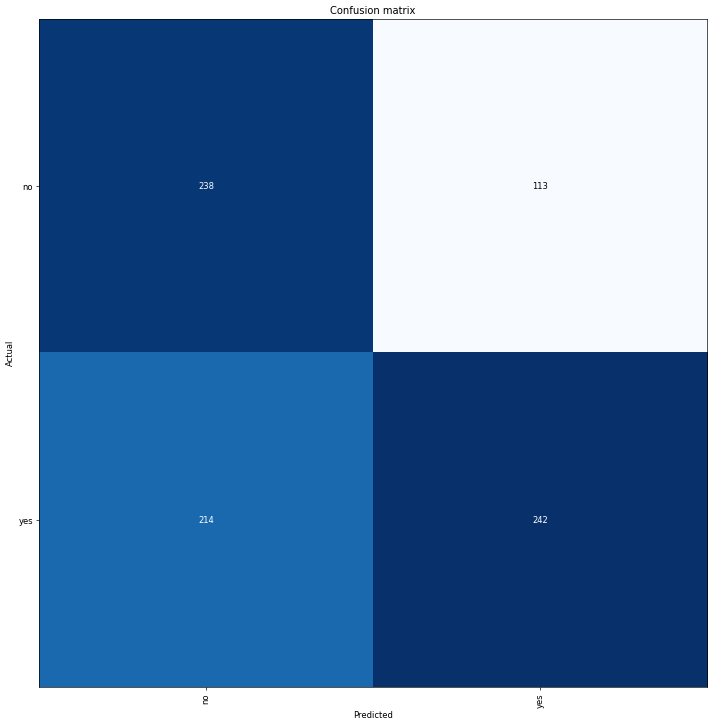

In [68]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [69]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5947955250740051.


(#4) [0.6740897297859192,0.5947955250740051,0.6816901408450704,0.5307017543859649]

## Ranger + Flat + MixUp

In [76]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [77]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.319026,1.008860,0.469419,0.488506,0.247813,00:32
1,1.301232,0.949813,0.484709,0.514423,0.311953,00:32


Better model found at epoch 0 with valid_loss value: 1.0088603496551514.


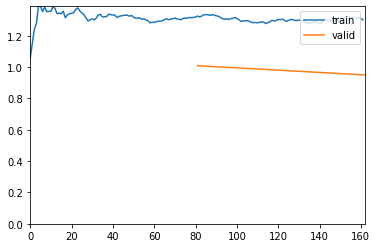

Better model found at epoch 1 with valid_loss value: 0.949812650680542.


In [78]:
learn.fit_flat_cos(2,lr=1e-3)

In [79]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.253614,0.898165,0.544343,0.542533,0.836735,00:37
1,1.100816,0.825415,0.558104,0.620536,0.405248,00:37
2,0.974797,0.754800,0.507645,0.549763,0.338192,00:37
3,0.883646,0.685375,0.553517,0.587031,0.501458,00:37
4,0.787081,0.671900,0.574924,0.605178,0.545190,00:37
5,0.733378,0.660105,0.603976,0.692661,0.440233,00:38
6,0.699365,0.662930,0.600917,0.727778,0.381924,00:38
7,0.693086,0.653064,0.623853,0.690196,0.513120,00:37
8,0.671392,0.661058,0.597859,0.715054,0.387755,00:37
9,0.674461,0.647241,0.593272,0.705882,0.384840,00:37


Better model found at epoch 0 with valid_loss value: 0.8981651067733765.


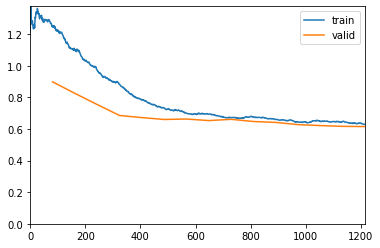

Better model found at epoch 1 with valid_loss value: 0.8254150152206421.
Better model found at epoch 2 with valid_loss value: 0.7547999024391174.
Better model found at epoch 3 with valid_loss value: 0.6853747963905334.
Better model found at epoch 4 with valid_loss value: 0.6718999147415161.
Better model found at epoch 5 with valid_loss value: 0.6601048707962036.
Better model found at epoch 7 with valid_loss value: 0.6530636548995972.
Better model found at epoch 9 with valid_loss value: 0.6472405791282654.
Better model found at epoch 10 with valid_loss value: 0.6414405107498169.
Better model found at epoch 11 with valid_loss value: 0.6274529099464417.
Better model found at epoch 12 with valid_loss value: 0.6214513778686523.
Better model found at epoch 13 with valid_loss value: 0.6164945363998413.
Better model found at epoch 14 with valid_loss value: 0.6153395771980286.


In [80]:
learn.fit_flat_cos(15,lr=1e-2)

In [81]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [82]:
learn.dls = dlsTest

In [83]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6790582537651062.


(#4) [0.5954667329788208,0.6790582537651062,0.8316498316498316,0.5416666666666666]

## Ranger + MixUp

In [88]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [89]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.363842,1.009040,0.480122,0.508475,0.262391,00:32
1,1.272389,0.931249,0.487768,0.516000,0.376093,00:32


Better model found at epoch 0 with valid_loss value: 1.0090398788452148.


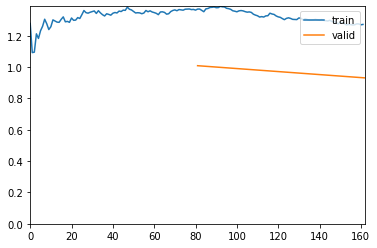

Better model found at epoch 1 with valid_loss value: 0.9312487244606018.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.262136,0.922772,0.483180,0.509881,0.376093,00:37
1,1.241186,0.920846,0.478593,0.504274,0.344023,00:37
2,1.216655,0.908257,0.474006,0.498039,0.370262,00:38
3,1.220718,0.876871,0.477064,0.502075,0.352770,00:37
4,1.158565,0.884562,0.477064,0.502304,0.317784,00:37
5,1.162686,0.854063,0.500000,0.534188,0.364431,00:37
6,1.111912,0.835235,0.489297,0.519651,0.346939,00:37
7,1.100486,0.840383,0.481651,0.509709,0.306122,00:37
8,1.077964,0.812190,0.513761,0.548638,0.411079,00:37
9,1.083712,0.830654,0.483180,0.511013,0.338192,00:38


Better model found at epoch 0 with valid_loss value: 0.9227720499038696.


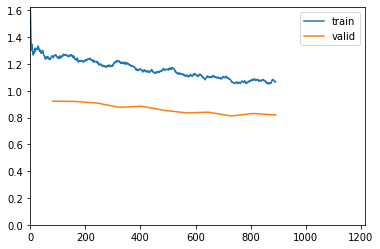

Better model found at epoch 1 with valid_loss value: 0.9208456873893738.
Better model found at epoch 2 with valid_loss value: 0.9082568883895874.
Better model found at epoch 3 with valid_loss value: 0.8768712878227234.
Better model found at epoch 5 with valid_loss value: 0.8540626764297485.
Better model found at epoch 6 with valid_loss value: 0.8352349400520325.
Better model found at epoch 8 with valid_loss value: 0.8121901750564575.
No improvement since epoch 8: early stopping


In [90]:
learn.fine_tune(15,freeze_epochs=2)

In [91]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [92]:
learn.dls = dlsTest

In [93]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4993804097175598.


(#4) [0.8225640058517456,0.4993804097175598,0.5828025477707006,0.40131578947368424]

## Faltten + MixUp

In [99]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.275895,0.858971,0.541284,0.597285,0.384840,00:31
1,0.973161,0.706668,0.585627,0.632353,0.501458,00:31


Better model found at epoch 0 with valid_loss value: 0.8589709997177124.


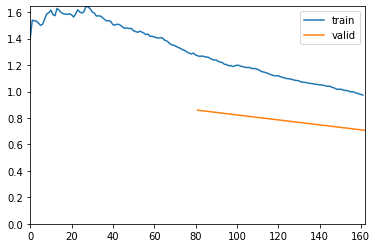

Better model found at epoch 1 with valid_loss value: 0.7066680192947388.


In [100]:
learn.fit_flat_cos(2,lr=1e-3)

In [101]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.000150,1.178955,0.524465,0.524465,1.000000,00:37
1,1.050261,8.420535,0.496942,0.594595,0.128280,00:37
2,1.092069,0.777664,0.475535,0.000000,0.000000,00:37
3,1.114723,0.692269,0.524465,0.524465,1.000000,00:37
4,1.032936,0.738819,0.524465,0.524465,1.000000,00:37
5,1.072755,0.700537,0.475535,0.000000,0.000000,00:37
6,1.043022,112.633194,0.509174,0.557895,0.309038,00:37


Better model found at epoch 0 with valid_loss value: 1.178955078125.


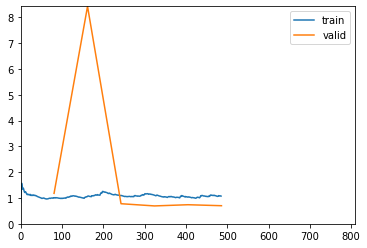

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with valid_loss value: 0.7776640057563782.
Better model found at epoch 3 with valid_loss value: 0.6922688484191895.
No improvement since epoch 3: early stopping


In [102]:
learn.fit_flat_cos(10,lr=1e-2)

In [103]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [104]:
learn.dls = dlsTest

In [105]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6860317587852478,0.565055787563324,0.5650557620817844,1.0]

## Ranger + Label

In [106]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [107]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.312415,0.922002,0.487768,0.516129,0.373178,00:31
1,1.292125,0.875512,0.507645,0.541833,0.396501,00:32


Better model found at epoch 0 with valid_loss value: 0.922002375125885.


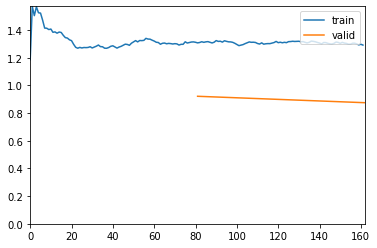

Better model found at epoch 1 with valid_loss value: 0.8755122423171997.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.230179,0.870565,0.509174,0.541045,0.422741,00:37
1,1.188577,0.875363,0.513761,0.550201,0.399417,00:37
2,1.185138,0.855852,0.498471,0.527473,0.419825,00:37
3,1.153936,0.833176,0.518349,0.548611,0.460641,00:37
4,1.156713,0.819789,0.545872,0.572327,0.530612,00:37
5,1.136969,0.799909,0.547401,0.580205,0.495627,00:37
6,1.092000,0.790696,0.518349,0.551095,0.440233,00:37
7,1.037497,0.797784,0.536697,0.573529,0.454810,00:37
8,1.036692,0.791724,0.532110,0.565371,0.466472,00:38
9,1.038520,0.774608,0.545872,0.571429,0.536443,00:37


Better model found at epoch 0 with valid_loss value: 0.8705649375915527.


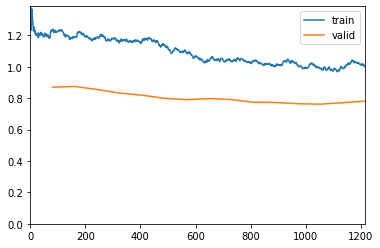

Better model found at epoch 2 with valid_loss value: 0.8558515906333923.
Better model found at epoch 3 with valid_loss value: 0.8331764340400696.
Better model found at epoch 4 with valid_loss value: 0.8197891116142273.
Better model found at epoch 5 with valid_loss value: 0.7999086380004883.
Better model found at epoch 6 with valid_loss value: 0.7906962633132935.
Better model found at epoch 9 with valid_loss value: 0.7746080160140991.
Better model found at epoch 10 with valid_loss value: 0.7729499936103821.
Better model found at epoch 11 with valid_loss value: 0.765060305595398.
Better model found at epoch 12 with valid_loss value: 0.7622218132019043.


In [108]:
learn.fine_tune(15,freeze_epochs=2)

In [109]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [110]:
learn.dls = dlsTest

In [111]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5613383054733276.


(#4) [0.7373044490814209,0.5613383054733276,0.6342105263157894,0.5285087719298246]

## Faltten + Label

In [112]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.300784,0.812172,0.579511,0.629771,0.481050,00:31
1,0.948307,0.755704,0.567278,0.613636,0.472303,00:31


Better model found at epoch 0 with valid_loss value: 0.8121723532676697.


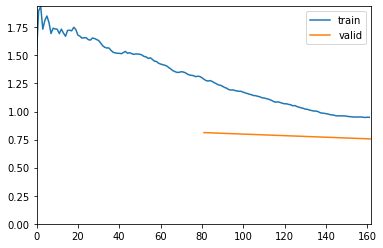

Better model found at epoch 1 with valid_loss value: 0.7557039856910706.


In [113]:
learn.fit_flat_cos(2,lr=1e-3)

In [114]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.5848931980144698e-06)

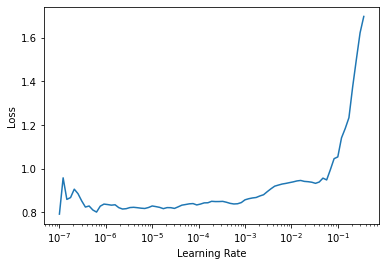

In [115]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.966738,5.040332,0.509174,0.525943,0.650146,00:37
1,1.000921,3.455012,0.521407,0.526690,0.862974,00:37
2,0.975870,17.626665,0.529052,0.529118,0.927114,00:37
3,1.021345,0.718924,0.475535,0.000000,0.000000,00:37
4,1.077441,1.374223,0.510703,0.666667,0.134111,00:37
5,1.015662,0.745277,0.472477,0.000000,0.000000,00:37
6,0.976014,2.745284,0.475535,0.500000,0.034985,00:37


Better model found at epoch 0 with valid_loss value: 5.040332317352295.


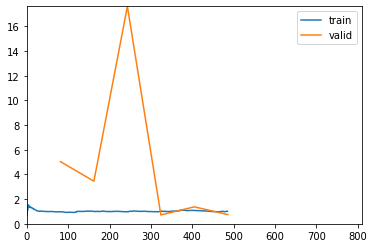

Better model found at epoch 1 with valid_loss value: 3.4550116062164307.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with valid_loss value: 0.7189235687255859.
No improvement since epoch 3: early stopping


In [116]:
learn.fit_flat_cos(10,lr=1e-2)

In [117]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [118]:
learn.dls = dlsTest

In [119]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.7326368093490601,0.4349442422389984,0.0,0.0]

## Label + MixUp

In [123]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.309853,1.052275,0.512232,0.561224,0.320700,00:31
1,1.074142,0.737564,0.541284,0.552567,0.658892,00:31


Better model found at epoch 0 with valid_loss value: 1.05227530002594.


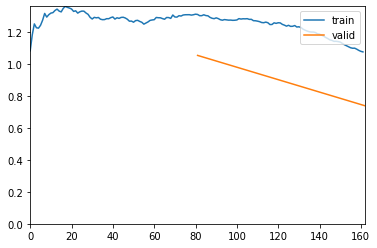

Better model found at epoch 1 with valid_loss value: 0.737563967704773.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.778067,0.694197,0.551988,0.576687,0.548105,00:37
1,0.757349,0.694676,0.568807,0.583562,0.620991,00:37
2,0.721622,0.677622,0.588685,0.588942,0.714286,00:37
3,0.701737,0.683348,0.605505,0.636656,0.577259,00:37
4,0.689440,0.657754,0.625382,0.728972,0.454810,00:37
5,0.674913,0.661663,0.643731,0.666667,0.641399,00:37
6,0.668968,0.687512,0.610092,0.809859,0.335277,00:37
7,0.659147,0.634810,0.655963,0.750000,0.516035,00:37
8,0.646767,0.633283,0.659021,0.647059,0.769679,00:37
9,0.635627,0.631837,0.652905,0.653439,0.720117,00:37


Better model found at epoch 0 with valid_loss value: 0.6941967606544495.


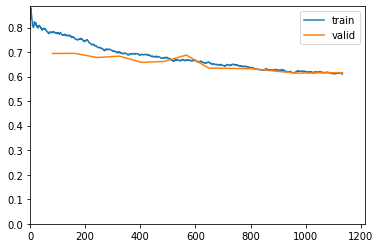

Better model found at epoch 2 with valid_loss value: 0.6776224970817566.
Better model found at epoch 4 with valid_loss value: 0.6577536463737488.
Better model found at epoch 7 with valid_loss value: 0.6348097920417786.
Better model found at epoch 8 with valid_loss value: 0.6332825422286987.
Better model found at epoch 9 with valid_loss value: 0.6318367123603821.
Better model found at epoch 10 with valid_loss value: 0.6221228241920471.
Better model found at epoch 11 with valid_loss value: 0.6139168739318848.
No improvement since epoch 11: early stopping


In [124]:
learn.fine_tune(15,freeze_epochs=2)

In [125]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [126]:
learn.dls = dlsTest

In [127]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7335811853408813.


(#4) [0.5631536245346069,0.7335811853408813,0.8196286472148541,0.6776315789473685]